In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats

In [102]:
# Load datasets

dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc") # GRACE data

Text(0, 0.5, 'Surface load (mm water equiv.)')

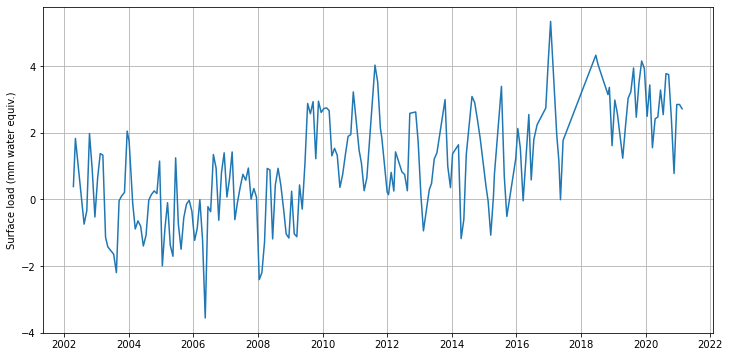

In [3]:
# surface mass load for seattle

seattle = ds.isel(lat=47, lon=-122)
plt.subplots(figsize=(12,6))
plt.plot(seattle.time,seattle.lwe_thickness)
plt.grid()
plt.ylabel('Surface load (mm water equiv.)')

In [161]:
number_of_time_steps = len(ds.time)
data_matrix = np.zeros((360*720,number_of_time_steps))

for i in range(number_of_time_steps):
    this_data = ds.isel(time=i).lwe_thickness
    data_matrix[:,i] = this_data.values.flatten()
    
#     fig,ax = plt.subplots(figsize=(12,12))
#     globe_2010.plot(vmin=-10,vmax=10)

## Singular Value Decomposition

The Singular Value Decomposition writes a matrix D as:

D = U * S * V

In [204]:
from scipy.sparse.linalg import svds

u,s,v = svds(data_matrix,k=7) # why are we using k=7?
# print(s)

## Plotting eigenvalues

In [205]:
# Explained variance = the amount of variance explained by each of the selected components. 

explained_var = np.flip(s, 0)
normalized_ex_var = explained_var/sum(s)

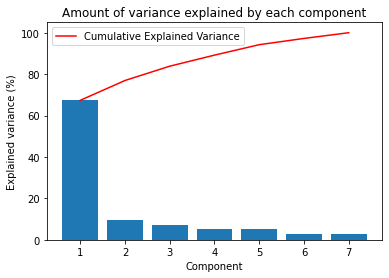

In [206]:
plt.bar(range(1,len(s)+1),normalized_ex_var*100)
plt.title("Amount of variance explained by each component")
plt.xlabel("Component")
plt.ylabel("Explained variance (%)")
plt.plot(range(1,len(explained_var)+1),
         np.cumsum(normalized_ex_var*100),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

In [212]:
def plot_eigenvalues(which_mode):
    first_left_singular_vector = np.reshape(u[:,which_mode],this_data.values.shape)
    first_right_singular_vector = v[which_mode,:]
    
    plt.subplots(2,1,figsize=(12,12))
    plt.subplot(2,1,1)
    plt.pcolor(first_left_singular_vector,vmin=-0.005,vmax=0.005)
    plt.colorbar()
    #plt.xlabel()
    #plt.ylabel()
    plt.title('Changes in surface mass load (mm water equiv.) on world map')
    plt.subplot(2,1,2)
    plt.plot(ds.time,first_right_singular_vector)
    plt.xlabel('Year')
    plt.ylabel('Surface load (mm water equiv.)')
    plt.title("Surface mass load from 2002 to 2021")
    
    
print(first_left_singular_vector.shape)
print(first_right_singular_vector.shape)

(360, 720)
(194,)


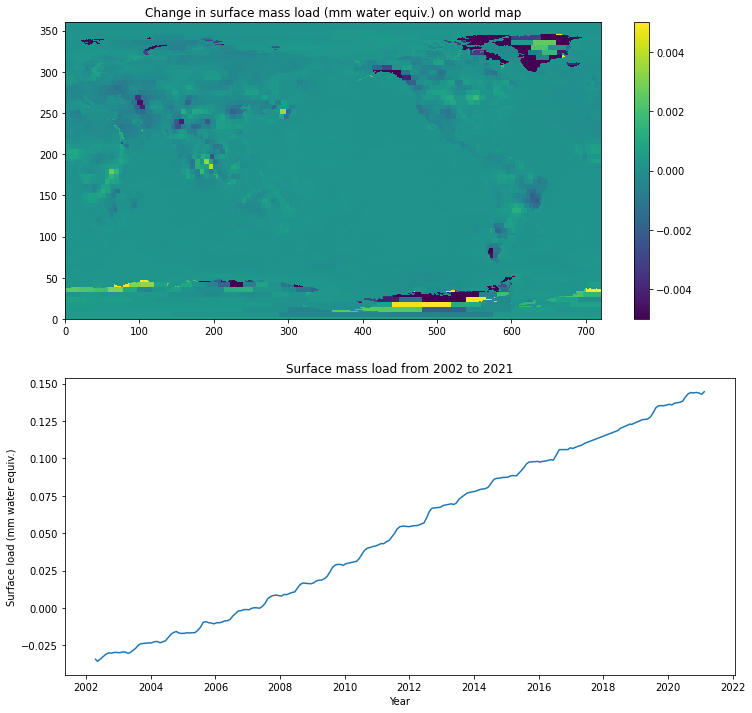

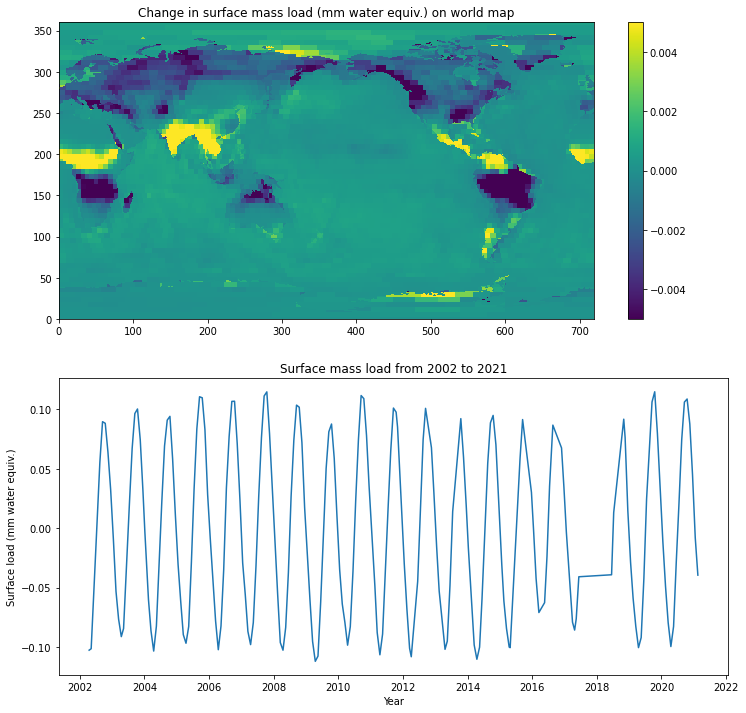

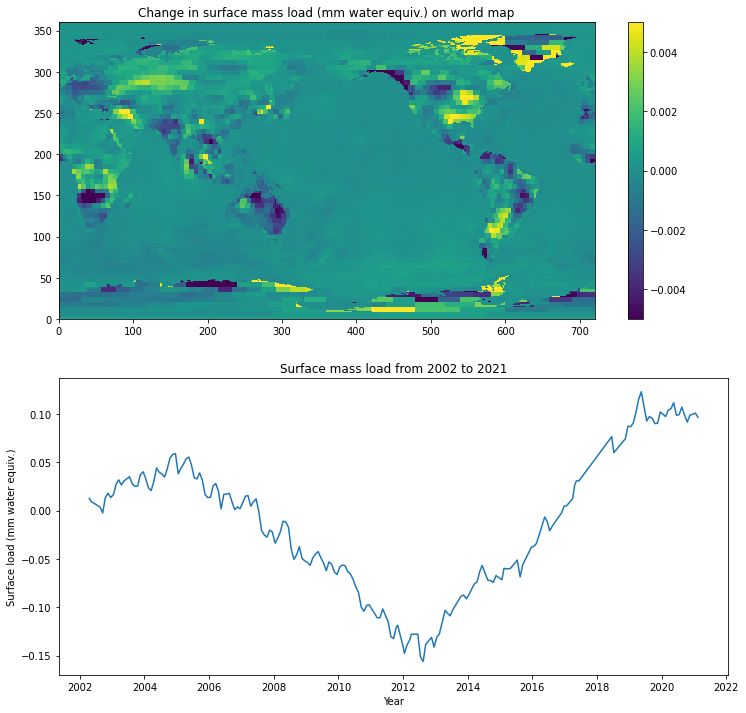

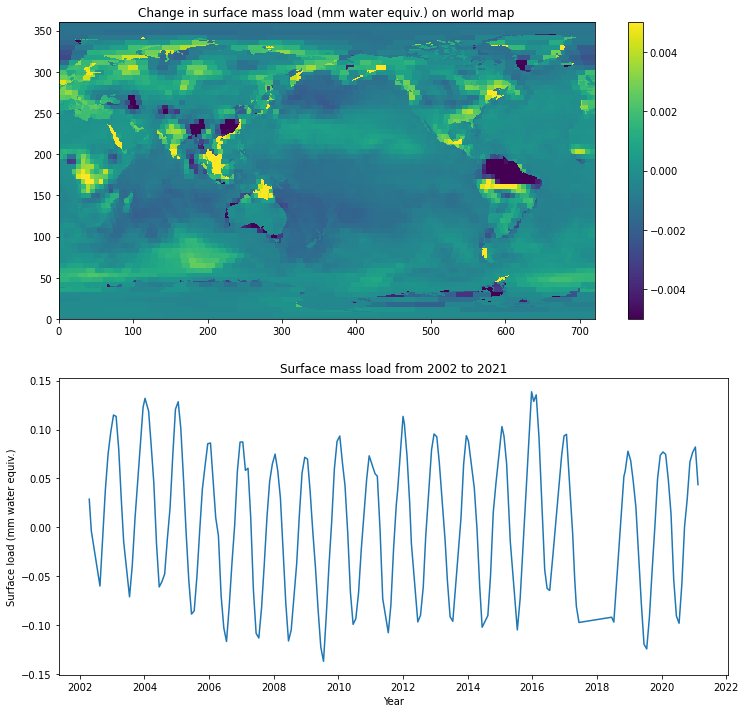

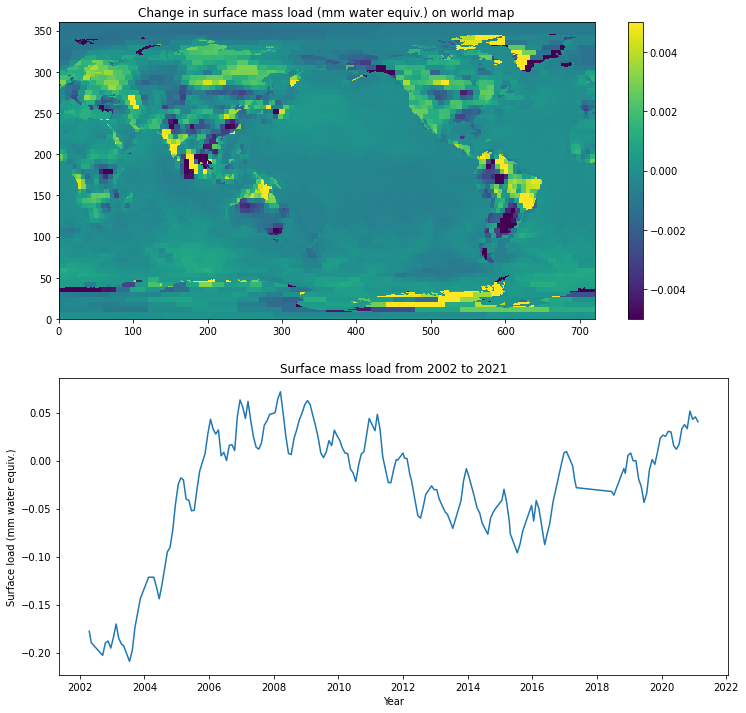

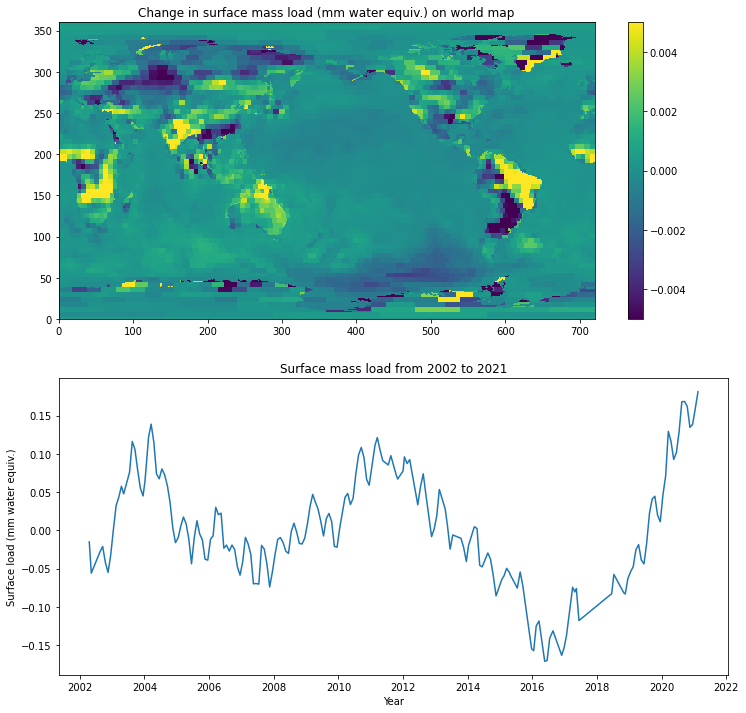

In [211]:
# graphs arranged from spatial patterns constructed from first PC to sixth PC

n = 7

for i in range(1,n):
    plot_eigenvalues(n-i)

In [165]:
n

7

In [9]:
s[6]/sum(s)

0.6733909027650883

## Calculation of the surface mass load at a given point in space and time

D = U * S * V, so to approximate D using the first mode, you would use

D = U[:,6]*S[6]@V[6,:]

Then every column will need to be np.reshaped()'d to the right size to make a map

In [10]:
type(data_matrix)
print(u[:,6].shape)
print(s[6].shape)
print(v[6,:].shape)

(259200,)
()
(194,)


In [14]:
# come back to this later! 

# # Finds index of closest time to some input time
# time_index = np.argmin(np.abs(ds.time.values - np.datetime64('2010-01-01')))
# this_latitude = 47
# this_longitude = -122

# # Finds index of closest latitude to some input latitude
# lat_index = np.argmin(np.abs(ds.lat.values - this_latitude))

# # Finds index of closest longitude to some input longitude
# lon_index = np.argmin(np.abs(ds.lon.values - this_longitude))

# nlong = len(ds.lon)
# pos_index = (lat_index -1) * nlong + lon_index

# # (D is calculated using D_reconstruct())
# # D[pos_index, time_index] 


In [21]:
# why are we using a fixed time_index, this_lat, and this_long?

# n = 7
# plt.subplots(6,1,figsize=(12,42))

# for i in range (1,n):
#     data_reconstruction = first_left_singular_vector * s[n-i] * v[n-i, time_index]
#     plt.subplot(6,1,i)
#     c = plt.pcolor(ds.lon.values,ds.lat.values, data_reconstruction,vmin=-10,vmax=10, cmap = 'seismic')
#     plt.plot(this_longitude + 360, this_latitude,'og')
#     plt.colorbar(c)

## Reconstruction of the data using each primary component

In [ ]:
# Function for reconstruction of data

def D_reconstruct(which_PC):
    D_reconstruct = u[:,which_PC].reshape(259200,1)*s[which_PC]@v[which_PC,:].reshape(1,194)
    return D_reconstruct

### D = Reconstruction of the data using PCs

In [ ]:
n = 7

for i in range(1,n):
    exec(f'D_{i} = D_reconstruct(n - i)')
    
# D_1 is the reconstructed surface load data using first PC = D_reconstruct(6)
# D_2 is the reconstructed surface load data using second PC = D_reconstruct(5)

### Finding surface mass load at times when earthquakes occured from reconstructed data

In [ ]:
# Earthquake catalog with lat, long, time etc.

catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv') 
catalog["time"] = catalog["time"].astype("datetime64")

In [27]:
type(catalog)

In [28]:
catalog_array = catalog.to_numpy()

eq_lat = catalog_array[:,1]
eq_lon = catalog_array[:,2]
eq_time = catalog_array[:,3]
total = len(catalog)
D_eq_values = np.zeros(total)

pandas.core.frame.DataFrame

In [46]:
# Function to calculate a specific D value for time of earthquake

def calculate_D_eq(eq_time, eq_lat, eq_lon, which_D):
    time_index = np.argmin(np.abs(ds.time.values - np.datetime64(eq_time)))
    lat_index = np.argmin(np.abs(ds.lat.values - eq_lat))
    lon_index = np.argmin(np.abs(ds.lon.values - eq_lon))
    nlong = len(ds.lon)
    pos_index = (lat_index -1) * nlong + lon_index
    return which_D[pos_index, time_index]

# Function to calculate a D values value at times of earthquake occurence using 
# (specify using which primary component)

def calculate_D_eq_values(which_D):
    D_eq_values = [0 for i in range(total)]
    for i in range(total):
        D_eq_values[i] = calculate_D_eq(eq_time[i], eq_lat[i], eq_lon[i], which_D)
    return np.array(D_eq_values)

In [51]:
D_eq_1 = calculate_D_eq_values(D_1)
D_eq_2 = calculate_D_eq_values(D_2)
D_eq_3 = calculate_D_eq_values(D_3)
D_eq_4 = calculate_D_eq_values(D_4)
D_eq_5 = calculate_D_eq_values(D_5)
D_eq_6 = calculate_D_eq_values(D_6)

In [57]:
# saving reconstructed D values to csv files
    
# np.savetxt('D_1.csv', D_1, delimiter=',')
# np.savetxt('D_2.csv', D_2, delimiter=',')
# np.savetxt('D_3.csv', D_3, delimiter=',')
# np.savetxt('D_4.csv', D_4, delimiter=',')
# np.savetxt('D_5.csv', D_5, delimiter=',')
# np.savetxt('D_6.csv', D_6, delimiter=',')

In [58]:
# saving D values for times of earthquake occurence to csv file

# np.savetxt('D_eq_1.csv', D_eq_1, delimiter=',')
# np.savetxt('D_eq_2.csv', D_eq_2, delimiter=',')
# np.savetxt('D_eq_3.csv', D_eq_3, delimiter=',')
# np.savetxt('D_eq_4.csv', D_eq_4, delimiter=',')
# np.savetxt('D_eq_5.csv', D_eq_5, delimiter=',')
# np.savetxt('D_eq_6.csv', D_eq_6, delimiter=',')

In [ ]:
# First step for this notebook:  plot the second PC spatial pattern

## Singular Value Decomposition for detrended data

In [199]:
from scipy import signal

data_matrix_detrend = signal.detrend(data_matrix)

u,s,v = svds(data_matrix_detrend,k=7)

In [200]:
explained_var = np.flip(s, 0)
normalized_ex_var = explained_var/sum(s)

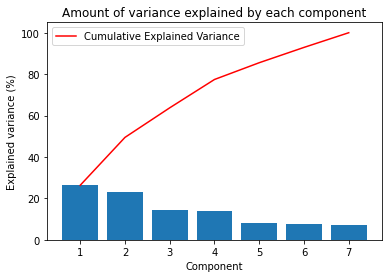

In [201]:
plt.bar(range(1,len(s)+1),normalized_ex_var*100)
plt.title("Amount of variance explained by each component")
plt.xlabel("Component")
plt.ylabel("Explained variance (%)")
plt.plot(range(1,len(explained_var)+1),
         np.cumsum(normalized_ex_var*100),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

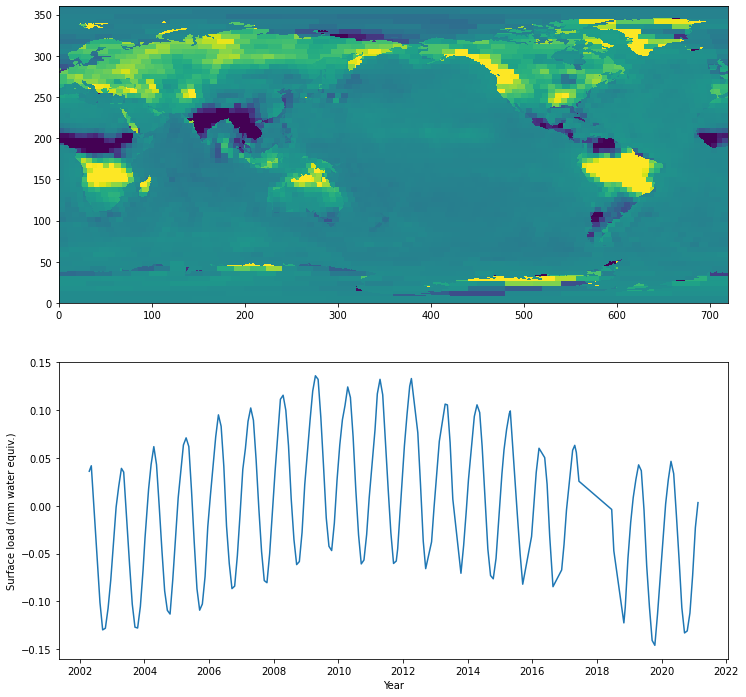

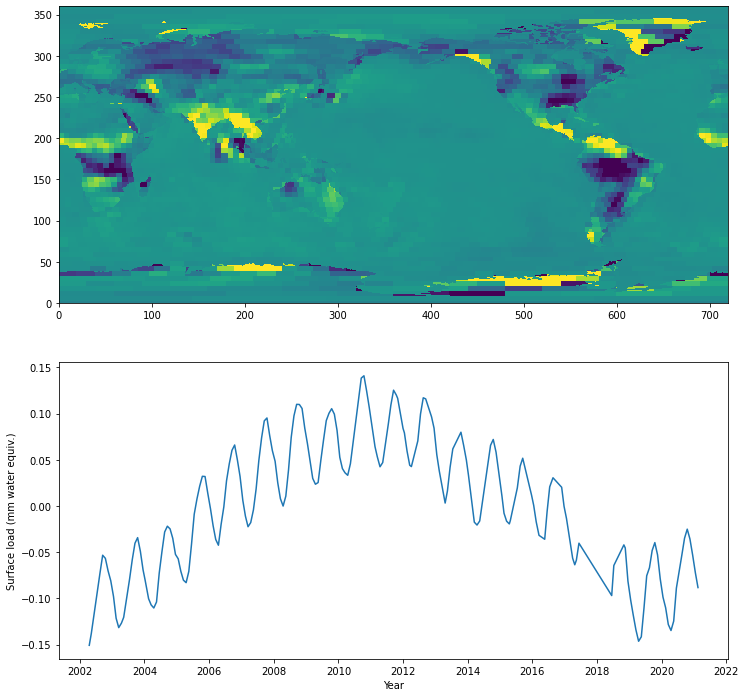

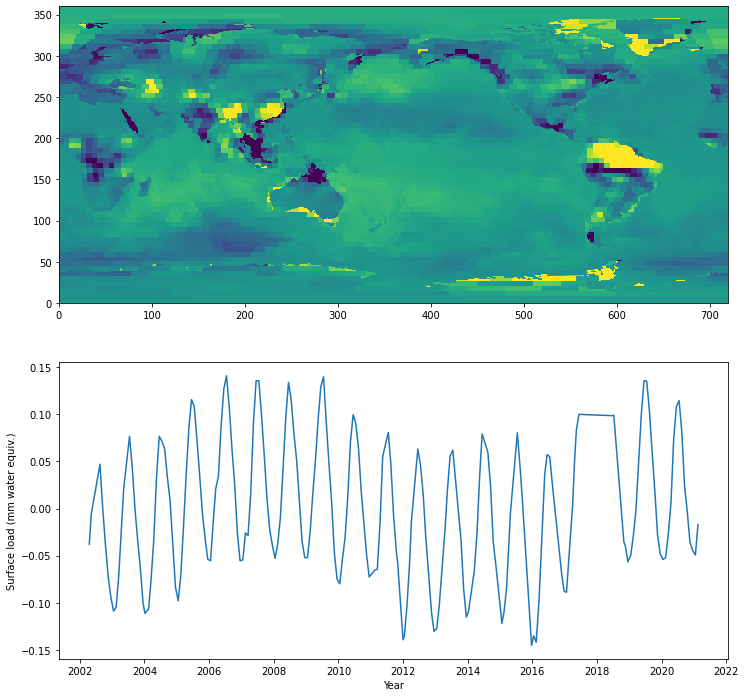

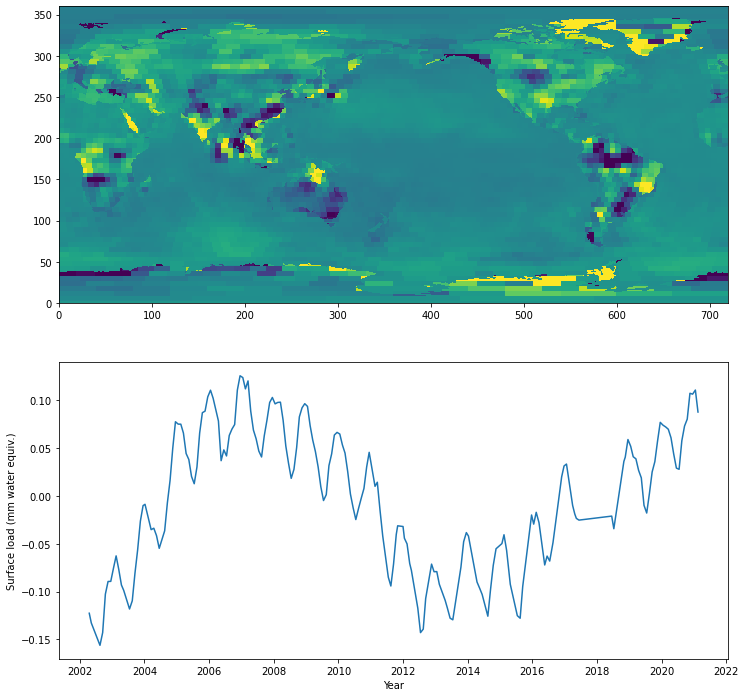

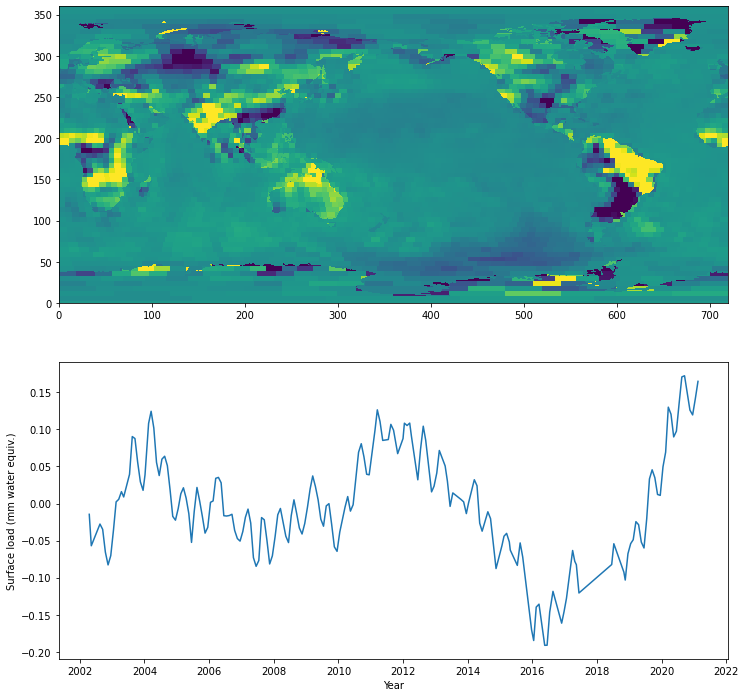

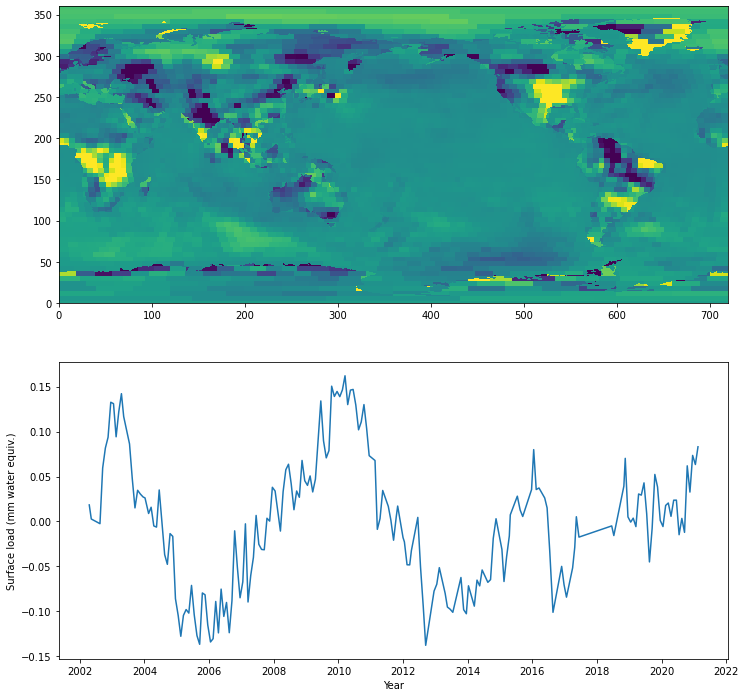

In [98]:
# graphs arranged from spatial patterns constructed from first PC to sixth PC

for i in range(1,7):
    plot_eigenvalues(n-i)

## Reconstruction of the detrended data using each primary component

In [80]:
n = 7

for i in range(1,n):
    exec(f'D_detrend_{i} = D_reconstruct(n - i)')

### Finding surface mass load at times when earthquakes occured from reconstructed data

In [83]:
D_detrend_eq_1 = calculate_D_eq_values(D_detrend_1)
D_detrend_eq_2 = calculate_D_eq_values(D_detrend_2)
D_detrend_eq_3 = calculate_D_eq_values(D_detrend_3)
D_detrend_eq_4 = calculate_D_eq_values(D_detrend_4)
D_detrend_eq_5 = calculate_D_eq_values(D_detrend_5)
D_detrend_eq_6 = calculate_D_eq_values(D_detrend_6)

In [88]:
# saving reconstructed D values to csv files
    
np.savetxt('D_detrend_1.csv', D_1, delimiter=',')
np.savetxt('D_detrend_2.csv', D_2, delimiter=',')
np.savetxt('D_detrend_3.csv', D_3, delimiter=',')
np.savetxt('D_detrend_4.csv', D_4, delimiter=',')
np.savetxt('D_detrend_5.csv', D_5, delimiter=',')
np.savetxt('D_detrend_6.csv', D_6, delimiter=',')

# saving D values for times of earthquake occurence to csv file

np.savetxt('D_detrend_eq_1.csv', D_eq_1, delimiter=',')
np.savetxt('D_detrend_eq_2.csv', D_eq_2, delimiter=',')
np.savetxt('D_detrend_eq_3.csv', D_eq_3, delimiter=',')
np.savetxt('D_detrend_eq_4.csv', D_eq_4, delimiter=',')
np.savetxt('D_detrend_eq_5.csv', D_eq_5, delimiter=',')
np.savetxt('D_detrend_eq_6.csv', D_eq_6, delimiter=',')